# 2018 10 29 Des Gabors pour V1
Finalement j'ai fini par regarder le github de NeuralEnsemble et il se trouve qu'ils avaient un code qui accompagne le blog. Ca serait trop simple de copier coller après tout le mal qu'on s'est donné mais par contre je peux reprendre la grande idée qui était d'assembler des filtres en gabor pour faire des V1 sensibles à une orientation particulière.

Bon au pire si ça prend trop de temps je forkerai directement de chez eux.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

video = np.load('../montypython.npy')
video = np.rot90(video)
print('Video shape', video.shape)

Video shape (54, 54, 4096)


In [4]:
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss



############
# Constants
############
total_time = 3000 #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

coo_min = len(video[:,:,0])/2 - 5
coo_max = len(video[:,:,0])/2 + 5
grid_res = 1.5

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res,coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

Filter array size (49, 2)


Video shape (54, 54, 4096)
Frames shape (54, 54)


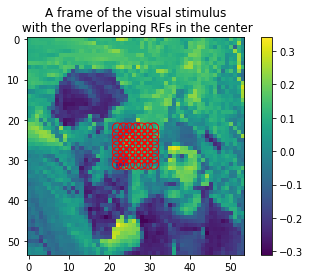

In [5]:
print('Video shape', video.shape)
print('Frames shape',video[:,:,0].shape)
plt.imshow(video[:,:,0], cmap = plt.cm.viridis)
plt.colorbar()
for filt in filters_coordinates :
    plt.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')

plt.title('A frame of the visual stimulus\n with the overlapping RFs in the center')
#plt.savefig('./figs/2018_10_24_MontyPython_frame.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

In [6]:
stimuli = video

In [7]:
###########
# Multiple filters 
###########

convo_list = []
st_list = [] # a list of spatiotemporal filters for tests with plotting
Xs = []
Ys = []

for filt in tqdm(range(len(filters_coordinates)), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           xres = filter_res, yres = filter_res,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    
    convo_list.append(ys)
    st_list.append(st)
    
    Xs.append(X)
    Ys.append(Y)


st_levels = []
for ft in range(len(st_list)):

    st_level = []
    for i in range(video.shape[-1]):
        st_level.append(np.max(st_list[ft][:,:,i]))
    st_levels.append(st_level)

Making filters: 100%|██████████| 49/49 [00:03<00:00, 15.97it/s]


# Génerer un Gabor et y associer des filtres

In [8]:
parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

In [15]:
phi.shape

(1, 2, 54, 54)

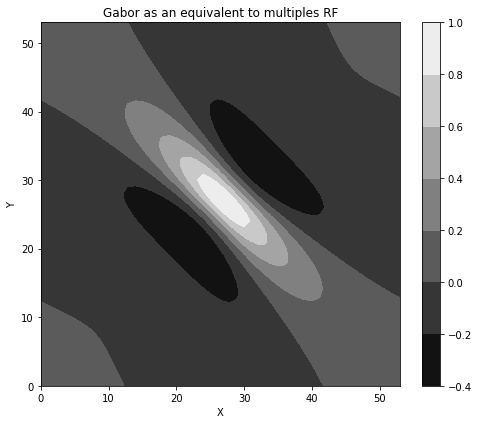

In [208]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.05, 'B_sf': .5, 'B_theta': B_theta}

N_phase = 2
theta = np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

fig, ax = plt.subplots(figsize = (7,6))
ax.contourf(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

for filt in filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor as an equivalent to multiples RF')
plt.tight_layout()

In [209]:
threshold = .5

gab_above_threshold = np.array([*np.where(phi[0,0] > threshold)], dtype = float).T #one-lineeeeer
print('There are %s points in the Gabor above the threshold' % str(gab_above_threshold.shape[0]))

filters_in_gabor = []
for it, filt in enumerate(filters_coordinates) :
    for gabs in gab_above_threshold :
        if np.all(filt == gabs) :
            filters_in_gabor.append(filt)
        
print('%s/%s ST filters are in the Gabor' % (len(filters_in_gabor),len(filters_coordinates) ))

There are 85 points in the Gabor above the threshold
7/49 ST filters are in the Gabor


In [210]:
filters_in_gabor

[array([22., 31.]),
 array([25., 28.]),
 array([25., 31.]),
 array([28., 25.]),
 array([28., 28.]),
 array([31., 22.]),
 array([31., 25.])]

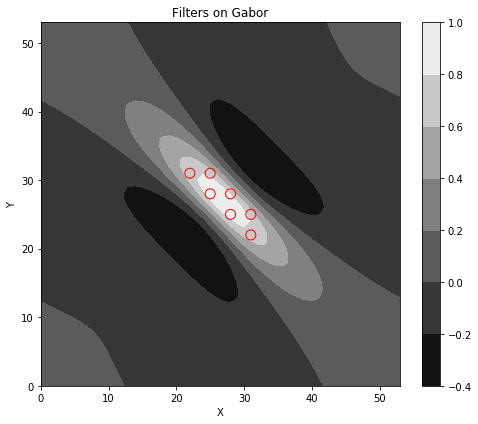

In [212]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.05, 'B_sf': .5, 'B_theta': B_theta}

N_phase = 2
theta = np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

fig, ax = plt.subplots(figsize = (7,6))
ax.contourf(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

for filt in filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Filters on Gabor')
plt.tight_layout()